In [1]:
# !pip install earthengine-api

In [2]:
import ee

In [3]:
# Trigger the authentication flow. if you want to user json, please comment this
ee.Authenticate()
# Initialize the library
# ee.Initialize(project='bukit30project')
ee.Initialize(project='ee-iwansetiawan')

In [4]:
# !pip install geemap

In [5]:
import sys
import os

# Connect to the path of the module
module_path = r'C:\Users\q_bal\Documents\Github\GEE_notebook_Forestry'

# Add the module path to sys.path
if module_path not in sys.path:
    sys.path.append(module_path)

In [6]:
# sys.path

In [7]:
#testing
import osi

In [8]:
# !pip install pycrs

In [9]:
# variables
# assigning variable, input for the analysis
############ VARIABLE INPUT ##########################################################################
start_date = '2023-6-1'
end_date = "2023-6-30"

project_name = 'delight_landscape'
map_name_arcgis_pro = 'Uganda'

# for planet labs image
region = 'africa' # or you can use 'asia'

create_training_gee = False

# cloud cover threshold, max per image, in image collection
cloud_cover_threshold = 40

# AOIt_shp_plot = geemap.shp_to_ee(AOIt_shp)
crs_input = 'EPSG:4326'

# choose the satellite image you want to use
I_satellite = 'Planet' # or 'Planet' or 'Sentinel'

#NDWI water limit
ndwi_hi_sentinel = 0.05 # for Sentinel
ndwi_hi_landsat = 0.1 # for landsat
ndwi_hi_planet = -0.2 # for Planet Labs

ndwi_hi = 0.1
if I_satellite == 'Landsat':
    ndwi_hi = ndwi_hi_landsat
elif I_satellite == 'Sentinel':
    ndwi_hi = ndwi_hi_sentinel
elif I_satellite == 'Planet':
    ndwi_hi = ndwi_hi_planet

pca_scaling = 1  # 1 meaning that 1 x pixel size of spatial resolution e.g., Planet Labs 1 x 5, Sentinel 1 x 10, Landsat 1 x 30
tileScale = 1 # increase this if user memory limit occur, see: https://gis.stackexchange.com/questions/373250/understanding-tilescale-in-earth-engine

######## HANSEN Tree Cover and Tree Cover Loss Input - Historical Data Check (10 Years Rule) ###################################################
# Hansen 10 years rule and Forest - Tree Cover Hansen
# define tree cover minimum that classified as forest e.g., Indonesia > 30%, hence 30
tree_cover_forest = 30 # this will be in percent, let's say, forest is > 30% if you put 30
pixel_number = 3 #define minimum mapping unit classified as forest, 1 pixel for landsat 30mx30, 3 pixel is forest ~> 0.27 Ha
year_start_loss = 14 #define start year to track as 10 years rule (e.g., 2012 to 2022 (track 10 years rule), hence 12. format= 00->2000, 12->2012)


## FCD Threshold
high_forest = 75
yrf_forest = 55
shrub_grass = 45
open_land = 30

# output Band Names
band_name_image = 'Class'

# ADD FIRST AOI TO ARCGIS MAP - option-1 in using existing shp to geemap
aoi_layer_name_in_map_arcgis = 'aoi_extent_delight'

# USE THE PATH FOR TRAINING DATA - option-2 in using existing shp to geemap
path_shp_input_training = r'G:\Shared drives\TREEO BD Supply\02. UGA\01. TPPs\03. Delight Ltd\Due Diligence\2024_07_24_Updated_Satellite_Assessment\raw_data_shp_script\00_input\training_aoi_smaller.shp'

In [11]:
# empower the capability of arcpy, native arcgis scripting from a class made
from osi.arcpy.main import ArcpyOps
import geemap

# Open the currently active project, you can also refer to actual project path, comment here below, and activate after
# project = arcpy.mp.ArcGISProject("CURRENT")
project_path = r'G:\My Drive\TreeO_WORKS\GIS_data\ArcGIS_Pro\TREEO\TREEO.aprx'
# project = arcpy.mp.ArcGISProject(project_path)
arc_ops= ArcpyOps(project_path_arcgis = project_path, map_name_arcgis= map_name_arcgis_pro)
layer_aoi = arc_ops.selecting_layer(name_layer = aoi_layer_name_in_map_arcgis)
AOIt_shp = layer_aoi.dataSource
print(f'path of the AOI: {AOIt_shp}')

##### AOI will be obtained its info directly from the project map in arcgisPro and convert that to ee object
## option-1 if this data already been added
AOI = geemap.shp_to_ee(AOIt_shp)

all_maps in project: ['Google Earth 2012', 'Flonares', 'Layers', 'Layers1', 'Layers2', 'Layers3', 'Layers4', 'KarakApung', 'MapDraftJustAnalysis', 'FSF', 'drafting_analysis', 'SRA', 'Map', 'STIHL_Request_futurecamp_FVW_UGA', 'Flonares_new_analysis', 'STIHL_FVW_IDN', 'eligibility_check_prospective_tpps', 'Map1', 'New Data Frame', 'New Data Frame 2', 'New Data Frame 21', 'New Data Frame 22', 'New Data Frame 23', 'New Data Frame 24', 'New Data Frame 25', 'New Data Frame 3', 'T4T_CSU', 'STIHL_Request_futurecamp_FVW_IDN', 'Uganda', 'T4T_Inset', 'T4T_Analysis', 'T4T_Layout_replant_first']
we will select the map for Uganda


NameError: name 'layer' is not defined

In [11]:
import pandas as pd
# lets print below the layer and convert into df if field names is exist
# Get the layer's attribute table fields
fields = [field.name for field in arcpy.ListFields(layer)]

# Initialize an empty list to hold the data
data = []

# Use a SearchCursor to iterate over the rows in the attribute table
with arcpy.da.SearchCursor(layer, fields) as cursor:
    for row in cursor:
        data.append(row)

# Create a pandas DataFrame from the data
df = pd.DataFrame(data, columns=fields)
display(df)

#for area id in shapefile that identified the data, and will converted into raster
OID = 'id'  #IMPORTANT TO CHECK OID based on the column ID
if OID not in fields:
    print(f'field_name of {OID} is not exist ERROR WILL HAPPEN!!!!')
    raise ValueError(f"Field '{OID}' not found in the fields: {fields}")
else:
    print(f"Field '{OID}' found. Proceeding with operations masking based on AOI \nplease continue")
    # Proceed with further operations, like converting to raster, etc.
    #############################################
    ##################################################################################
    ### Masking and overlay and area helper Make an image out of the AOI area attribute -> convert featurecollection into raster (image) for overlaying tools
    AOI_img = AOI.filter(ee.Filter.notNull([OID])).reduceToImage(
        properties= [OID],
        reducer= ee.Reducer.first()
    )

,FID,Shape,id,width,height,area,perimeter
0,0,"(31.727862700000014, 2.6536045999999827)",0,0.049972,0.03935,0.001966,0.178644


Field 'id' found. Proceeding with operations masking based on AOI 
please continue


In [12]:
# option-2 if we want to add the data as layer from path and adding the layer programmatically
# let's try for this training points (sample) to be added as layer in our current map

# Define a helper function to safely get the data source
def safe_get_data_source(layer):
    try:
        if layer.isFeatureLayer:
            return layer.dataSource
        else:
            return "Not a feature layer or no data source available"
    except Exception as e:
        return f"Error: {str(e)}"

list_source_layers_in_map = [safe_get_data_source(layer) for layer in map.listLayers()]

if path_shp_input_training not in list_source_layers_in_map:
    map.addDataFromPath(path_shp_input_training)
else:
    print('layer input training is already added, check it on the map, save it in the same path if you edited')


layer input training is already added, check it on the map, save it in the same path if you edited


In [13]:
# convert the modules for image collection (cloudless masking, compositing, reducer etc)
from osi.image_collection.main import ImageCollection

In [14]:
classInputCollection = ImageCollection(I_satellite=I_satellite,
                                       AOI=AOI, 
                                       date_start_end=[start_date,end_date], 
                                       cloud_cover_threshold = cloud_cover_threshold,
                                       region=region)

In [15]:
# run the method from image collection loaded, cloudless compositing until to image_mosaick
image_mosaick = classInputCollection.image_mosaick()

selecting Planet images


In [16]:
vis_params_image_mosaick = {"bands":["red","green","blue"],"min":0,"max":0.1,"gamma":1}
layer_name_image_mosaick = f'image_mosaick_result_ee_{project_name}'

def adding_ee_to_arcgisPro(ee_image, vis_params, layer_name):
    map_id_dict = ee_image.getMapId(vis_params)
    url_tiles  = map_id_dict['tile_fetcher'].url_format
    print(url_tiles)
    
    list_name_layers_in_map = [layer.name for layer in map.listLayers()]
    if layer_name not in list_name_layers_in_map:
        arcgis_layer = map.addDataFromPath(url_tiles)
        arcgis_layer.name = layer_name
    else:
        print(f'removing and re-adding the layer name: {layer_name}')
        arcgis_layer = map.removeLayer([layer for layer in map.listLayers() if layer.name == layer_name][0])
        arcgis_layer = map.addDataFromPath(url_tiles)
        arcgis_layer.name = layer_name
        print(f'layer re-added: {layer_name}')
        
    return arcgis_layer
    
image_mosaick_arcgis_layer = adding_ee_to_arcgisPro(image_mosaick, vis_params_image_mosaick,
                                                   layer_name_image_mosaick)

https://earthengine.googleapis.com/v1/projects/ee-iwansetiawan/maps/ef7f6c44fb421920d903151fcb58d4aa-2221414081473b5152e3e739ddcfca64/tiles/{z}/{x}/{y}
removing and re-adding the layer name: image_mosaick_result_ee_delight_landscape
layer re-added: image_mosaick_result_ee_delight_landscape


In [17]:
from osi.spectral_indices.spectral_analysis import SpectralAnalysis
from osi.spectral_indices.utils import normalization_100

# since the class is using config for some reason (simplicity), different with the ImageCollection
config = {'I_satellite':I_satellite,
         'pca_scaling':pca_scaling,
         'tileScale':tileScale,
         'AOI':AOI, 
         'date_start_end':[start_date,end_date],
         'pixel_number': pixel_number,
         'year_start_loss':year_start_loss,
         'tree_cover_forest':tree_cover_forest,
         'fcd_selected': 21, #if you want to put as variable, do it later, but lets make it default
         }


classImageSpectral = SpectralAnalysis(image_mosaick,config)

In [18]:
from osi.fcd.main_fcd import FCDCalc

from osi.pca.pca_gee import PCA

IsThermal = False
config['region'] = region
# config['I_satellite'] = I_satellite
config['IsThermal'] = IsThermal
# config['AOI'] = AOI
# config['date_start_end'] = date_start_end
config['cloud_cover_threshold'] = cloud_cover_threshold


class_FCD_run = FCDCalc(config).fcd_calc()
FCD1_1 = class_FCD_run['FCD1_1']
FCD2_1 = class_FCD_run['FCD2_1']

FCD1_1_arcgis_layer = adding_ee_to_arcgisPro(FCD1_1, {'min':0 ,'max':80, 'palette':['ff4c16', 'ffd96c', '39a71d']},
                                                   f'FCD1_1_{project_name}')

FCD2_1_arcgis_layer = adding_ee_to_arcgisPro(FCD2_1, {'min':0 ,'max':80, 'palette':['ff4c16', 'ffd96c', '39a71d']},
                                                   f'FCD2_1_{project_name}')

print('finish processing PCA please continue')

selecting Planet images
selecting Planet images
processing AVI
processing BSI
processing SI
Normalizing to 100 AVI
Normalizing to 100 AVI
Normalizing to 100 BSI
Normalizing to 100 SI
Combining AVI AND BSI
no thermal band, choosing Planet images
Processing means center of AVI_BSI please wait
Now we proceed to the PCA of Vegetation density
Success get the PCA normalized of VD => SVI
Now calculating the FCD from SVI and SSI - selecting band svi1 svi2 ssi1 and ssi2
finish processing PCA, the result: FCD1_1 and FCD2_1 please continue
https://earthengine.googleapis.com/v1/projects/ee-iwansetiawan/maps/e808993823d5445622139a51f7a8306a-fbf7581daab9c3340cf8bca27a5b9a6f/tiles/{z}/{x}/{y}
removing and re-adding the layer name: FCD1_1_delight_landscape
layer re-added: FCD1_1_delight_landscape
https://earthengine.googleapis.com/v1/projects/ee-iwansetiawan/maps/c0cd22213935380dad5c40f19122aaac-c6ee287a1e7661058239138ea470e8c9/tiles/{z}/{x}/{y}
removing and re-adding the layer name: FCD2_1_delight_la

In [19]:
# Now this is historical data to overlay later with current baseline (landcover)
from osi.hansen.historical_loss import HansenHistorical
hansen_class = HansenHistorical(config)
run_hansen = hansen_class.initiate_tcl()
LastImageLandsat, treeLossYear, minLoss, ForestArea2000Hansen, gfc =  \
                                 run_hansen['LastImageLandsat'], \
                                 run_hansen['treeLossYear'], \
                                 run_hansen['minLoss'], \
                                 run_hansen['ForestArea2000Hansen'], \
                                 run_hansen['gfc']


In [20]:
from osi.classifying.assign_zone import AssignClassZone
config['open_land'] = open_land
config['shrub_grass']=shrub_grass
config['yrf_forest'] = yrf_forest
config['high_forest'] = high_forest
config['AOI_img'] = AOI_img
config['band_name_image'] = band_name_image

class_assigning_fcd =  AssignClassZone(config, FCD1_1=FCD1_1, FCD2_1=FCD2_1)
list_images_classified = class_assigning_fcd.assigning_fcd_class(gfc, minLoss)

Adding the map of Forest, FCD >= 55% and mask only if not water in area (hansen) and NDWI
Adding the map of Shrubland, FCD <  55% and FCD >= 45%
Adding the map of Grassland or Openland, FCD  < 45%
Processing - the zoning classification
finish processing, merging all the zone into one image


In [21]:
fcd_classified_zone = list_images_classified['all_zone']
vis_params_fcd_classified = list_images_classified['vis_param_merged']

fcd_classified_zone_arcgis_layer = adding_ee_to_arcgisPro(fcd_classified_zone, vis_params_fcd_classified,
                                                   f'FCD_classified_zone_{project_name}')

https://earthengine.googleapis.com/v1/projects/ee-iwansetiawan/maps/ba6d2ecf7026892a445f432d582088c7-b307b038c1af562f893e9cf382c18fe1/tiles/{z}/{x}/{y}
removing and re-adding the layer name: FCD_classified_zone_delight_landscape
layer re-added: FCD_classified_zone_delight_landscape


In [22]:
list_images_classified['vis_param_merged']
list_images_classified['legend_class']

{'1': {'name': 'Shrubland_Go-Zone', 'color': '#ffe3b3'},
 '2': {'name': 'Grassland_Go-Zone', 'color': '#ffff33'},
 '3': {'name': 'Openland_Go-Zone', 'color': '#F89696'},
 '4': {'name': 'High density Forest', 'color': '#09ab0c'},
 '5': {'name': 'Low - Medium density Forest', 'color': '#83ff5a'},
 '6': {'name': 'Regrowth High Density Forest from deforested (historical)',
  'color': '#ff0004'},
 '7': {'name': 'Regrowth Low Density Forest from deforested (historical)',
  'color': '#ff0abe'},
 '8': {'name': 'Historical deforestation (10 years rule)', 'color': '#ff8a1d'},
 '9': {'name': 'Water Body', 'color': '#1900ff'},
 '10': {'name': 'Plantation_No_GO-Zone', 'color': '#e6e6fa'},
 '11': {'name': 'Infrastructure_No_GO-Zone', 'color': '#FFFFFF'}}

In [23]:
from osi.legends.utils import convert_to_legend_items

# Convert the dictionary to the LEGEND_ITEMS format
legend_items = convert_to_legend_items(list_images_classified['legend_class'])

# Print the result
print(legend_items)

[{'color': '#ffe3b3', 'label': '1: Shrubland_Go-Zone'}, {'color': '#ffff33', 'label': '2: Grassland_Go-Zone'}, {'color': '#F89696', 'label': '3: Openland_Go-Zone'}, {'color': '#09ab0c', 'label': '4: High density Forest'}, {'color': '#83ff5a', 'label': '5: Low - Medium density Forest'}, {'color': '#ff0004', 'label': '6: Regrowth High Density Forest from deforested (historical)'}, {'color': '#ff0abe', 'label': '7: Regrowth Low Density Forest from deforested (historical)'}, {'color': '#ff8a1d', 'label': '8: Historical deforestation (10 years rule)'}, {'color': '#1900ff', 'label': '9: Water Body'}, {'color': '#e6e6fa', 'label': '10: Plantation_No_GO-Zone'}, {'color': '#FFFFFF', 'label': '11: Infrastructure_No_GO-Zone'}]


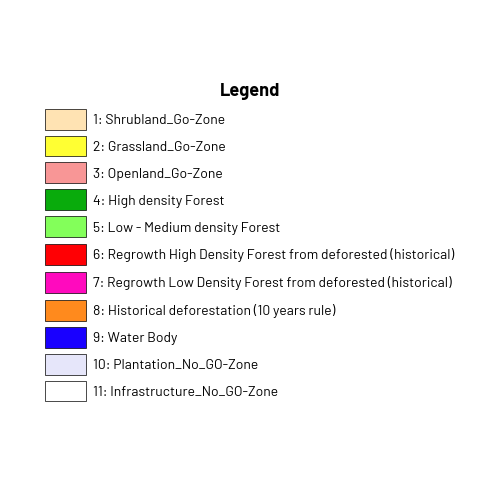

In [24]:
from osi.legends.main import LegendsBuilder

legend_class = LegendsBuilder(legend_items=legend_items)
legend_class.create_legend()


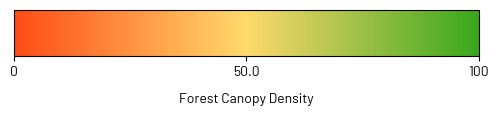

In [25]:
# custom color spectrum
legend_class.create_colorbar('Forest Canopy Density',{'min': 0, 'max': 100, 'palette': ['#ff4c16', '#ffd96c', '#39a71d']})

In [26]:
image_mosaick_all_bands = image_mosaick.addBands([FCD2_1.select('FCD').rename('FCD2_1'), FCD1_1.select('FCD').rename('FCD1_1')])

## ADDING DIRECTLY SPECTRAL INDICES
# classImageSpectral
pca_scale = classImageSpectral.pca_scale
ndwi_image = classImageSpectral.NDWI_func()
msavi2_image = classImageSpectral.MSAVI2_func()
mtvi2_image = classImageSpectral.MTVI2_func()
ndvi_image = classImageSpectral.NDVI_func()
vari_image = classImageSpectral.VARI_func()

image_mosaick_ndvi_ndwi_msavi2_mtvi2_vari = (
    image_mosaick_all_bands
    .addBands(ndwi_image)
    .addBands(msavi2_image)
    .addBands(mtvi2_image)
    .addBands(ndvi_image)
    .addBands(vari_image)
)

red_norm = normalization_100(image_mosaick.select(['red']), pca_scale=pca_scale, AOI=AOI)
green_norm = normalization_100(image_mosaick.select(['green']), pca_scale=pca_scale, AOI=AOI)
blue_norm = normalization_100(image_mosaick.select(['blue']), pca_scale=pca_scale, AOI=AOI)
nir_norm = normalization_100(image_mosaick.select(['nir']), pca_scale=pca_scale, AOI=AOI)

image_norm = red_norm.addBands(green_norm).addBands(blue_norm).addBands(nir_norm)

image_norm_ndvi = normalization_100(image_mosaick_ndvi_ndwi_msavi2_mtvi2_vari.select('NDVI'), pca_scale=pca_scale, AOI=AOI)
image_norm_ndwi = normalization_100(image_mosaick_ndvi_ndwi_msavi2_mtvi2_vari.select('ndwi'), pca_scale=pca_scale, AOI=AOI)
image_norm_msavi2 = normalization_100(image_mosaick_ndvi_ndwi_msavi2_mtvi2_vari.select('msavi2'), pca_scale=pca_scale, AOI=AOI)
image_norm_mtvi2 = normalization_100(image_mosaick_ndvi_ndwi_msavi2_mtvi2_vari.select('MTVI2'), pca_scale=pca_scale, AOI=AOI)
image_norm_vari = normalization_100(image_mosaick_ndvi_ndwi_msavi2_mtvi2_vari.select('VARI'), pca_scale=pca_scale, AOI=AOI)

# red_norm.bandNames().getInfo()
image_norm_with_spectral_indices = image_norm.addBands(image_norm_ndvi).addBands(image_norm_ndwi).addBands(image_norm_msavi2).addBands(image_norm_mtvi2).addBands(image_norm_vari)
image_norm_with_spectral_indices_FCD = image_norm_with_spectral_indices.addBands(FCD2_1.select('FCD').rename('FCD2_1')).addBands(FCD1_1.select('FCD').rename('FCD1_1'))



In [27]:
from osi.ml.main import LandcoverML

class_landCover = LandcoverML(input_image = image_mosaick_ndvi_ndwi_msavi2_mtvi2_vari,
                              pca_scale = pca_scale,
                              AOI = AOI)

In [29]:
class_landCover.stratified_random_creation()

['red', 'green', 'blue', 'nir', 'FCD2_1', 'FCD1_1', 'ndwi', 'msavi2', 'MTVI2', 'NDVI', 'VARI']


In [ ]:
# exploring SNIC - SEGMENTATION
#https://gis.stackexchange.com/questions/333413/is-google-earth-engine-snic-segmentation-algorithm-inconsistent

# defined superpixel size
# super_pixel_size = 10
super_pixel_size = 3

# Create a uniformly spaced seed grid
# seeds = ee.Algorithms.Image.Segmentation.seedGrid(super_pixel_size)

# Apply SNIC segmentation on the FCD image
snic = ee.Algorithms.Image.Segmentation.SNIC(
    # image=image_mosaick_all_bands_ndwi_msavi2_mtvi2_ndvi,
    # image=image_mosaick,
    # image=image_mosaick_ndvi_ndwi_msavi2_mtvi2,
    # image=image_mosaick_avi_norm,
    # image=image_norm,
    # image=image_norm_with_spectral_indices,
    image=image_norm_with_spectral_indices_FCD,
    # image= avi_norm,
    size=super_pixel_size,
    compactness=0,
    connectivity=8,
    neighborhoodSize=64,
    # seeds=seeds,
).reproject( # handling/apply the workaround of inconsistency https://gis.stackexchange.com/questions/333413/is-google-earth-engine-snic-segmentation-algorithm-inconsistent
  crs='EPSG:4326',
  scale=pca_scale)

# Map.addLayer(vectors, {}, 'snic-vector')

# Pull out the clusters layer, each cluster has a uniform value
clusters = snic.select('clusters')

# adding_ee_to_arcgisPro(clusters.randomVisualizer(), {}, f'clusters_random_{project_name}')

# Map.addLayer(clusters.randomVisualizer(), {}, 'Clusters')
# Visualize the cluster means
# clusterVis = {'bands': ['red_mean', 'green_mean', 'blue_mean'], 'min': 0, 'max': 1}
# Map.addLayer(snic, clusterVis, 'Cluster means')

In [ ]:
image_norm_with_spectral_indices_FCD.bandNames().getInfo()

In [ ]:
clusters = snic.select(['clusters'])

# #disable (comment) it if std_dev since makes user limit memory error
# # Compute the standard deviation of each cluster.
# stdDev_image = image_norm_with_spectral_indices_FCD.addBands(clusters).reduceConnectedComponents(
#   reducer =ee.Reducer.stdDev(),
#   labelBand= 'clusters',
#   maxSize=256,
# )

# Map.addLayer(stdDev_image, {'min': 0, 'max': .1}, 'Std dev')

# Compute the area of each cluster.
area_cluster = ee.Image.pixelArea().addBands(clusters).reduceConnectedComponents(
    reducer=ee.Reducer.sum(),
    labelBand='clusters',
    maxSize=256
  )
# Map.addLayer(area_cluster, {'min': 50000, 'max': 500000}, 'Area')

# Compute the perimeter of each cluster.
minMax = clusters.reduceNeighborhood(
  reducer= ee.Reducer.minMax(),
  kernel= ee.Kernel.square(1)
)
perimeterPixels = minMax.select(0).neq(minMax.select(1))
perimeter = perimeterPixels.addBands(clusters).reduceConnectedComponents(
    reducer=ee.Reducer.sum(),
    labelBand='clusters',
    maxSize= 256
  )
# Map.addLayer(perimeter, {'min': 0, 'max': 1000}, 'Perimeter')

# Compute the width and height of each cluster.
sizes = ee.Image.pixelLonLat().addBands(clusters).reduceConnectedComponents(
    reducer=ee.Reducer.minMax(),
    labelBand='clusters',
    maxSize=256,
  )
width = sizes.select('longitude_max').subtract(sizes.select('longitude_min')).rename('width')
height = sizes.select('latitude_max').subtract(sizes.select('latitude_min')).rename('height')
# Map.addLayer(width, { 'min': 0, 'max': 0.02 }, 'Width')
# Map.addLayer(height, { 'min': 0, 'max': 0.02 }, 'Height')

# only means number of these bands in clusters
mean_image_spectralindices_fcd = snic.select([
  'red_mean',
  'green_mean',
  'blue_mean',
  'nir_mean',
  'ndwi_mean',
  'msavi2_mean',
  'MTVI2_mean',
  'NDVI_mean',
  'VARI_mean',
  'FCD1_1_mean',
  'FCD2_1_mean',
])

## putting all together the info of additional stat and object info (perimeter, size, width, height)
object_properties_image = ee.Image.cat([
  mean_image_spectralindices_fcd,
#   stdDev_image, # comment this if make userlimit error - Output of image computation is too large
  area_cluster,
  perimeter,
  width,
  height
])

# # statistic_all_bands image
# stats_image_spectralindices_fcd = stats_image
stats_image_spectralindices_fcd = object_properties_image

In [ ]:
#k-means, first time only to create stratified random sampling
# K-MEANS UNSUPERVISED - Skip later after stratified random sampling created

number_class = 7 # 7 class expected: forest, shrub, grass, crop, water, infrastructure, plantation

# Perform k-means clustering - unsupervised class
training = stats_image_spectralindices_fcd.sample(region=AOI, scale=pca_scale, numPixels=10000) #scale is spatial resolution of Planet NICFI, numPixel (the bigger the better?) at least 100 per class for ha less than 500 or 10% of total pixel?, see: https://docs.google.com/spreadsheets/d/1J8MEi4IDn6faok6UUn9L64T61yWk0D4q/edit#gid=1919918133 to calculate manually (though its for stratified random sampling)
kmeans = ee.Clusterer.wekaKMeans(number_class).train(training) 
result_kmeans = object_properties_image.cluster(kmeans)

# Display the classified veg
# Map.addLayer(result.clip(AOIsmaller).randomVisualizer(), {}, 'K-means Clusters aoi')
# Map.addLayer(result.randomVisualizer(), {}, 'K-means Clusters -random color')
cluster_kmeans_random_color = adding_ee_to_arcgisPro(result_kmeans.randomVisualizer(), {}, 'cluster_kmeans_random_color')


In [ ]:
result_kmeans.bandNames().getInfo()

In [ ]:
import numpy as np

#create stratified random sampling based on K-means classes
# create_training_gee
if create_training_gee:
    print('yes')
    
    ########### SAMPLE NUMBER CREATION BASED ON https://docs.google.com/spreadsheets/d/1J8MEi4IDn6faok6UUn9L64T61yWk0D4q/edit?gid=1919918133#gid=1919918133
#     # example
#     strata_area_based_kmeans = {
#     'Forest': 100,
#     'Shrub': 100,
#     'Grass': 100,
#     'Crop': 100,
#     'Water': 100
#     }
    
    # try with K-means input
    result_kmeans = result_kmeans.select('cluster')
    
    # Calculate the area for each class
    def calculate_class_areas(image, region, scale,number_class):
        # Create a pixel area image
        pixel_area = ee.Image.pixelArea()

        # Mask the image for each class and calculate the area
        class_areas = {}
        for i in range(number_class):  # in number_class above variable (previous cell)
            class_mask = image.eq(i)
            area = pixel_area.updateMask(class_mask).reduceRegion(
                reducer=ee.Reducer.sum(),
                geometry=region,
                scale=scale,
                maxPixels=1e10
            ).get('area')

            class_areas[i] = area

        return class_areas

    # Get the results
    area_dict = calculate_class_areas(result_kmeans, AOI, pca_scale, number_class)

    strata_area_based_kmeans = {}
    
    # Convert areas from square meters to hectares and print them
    for class_id, area in area_dict.items():
        area_ha = ee.Number(area).divide(1e4).getInfo()  # Convert area from square meters to hectares
        print(f'Class {class_id}: {area_ha:.2f} Ha')
        strata_area_based_kmeans[str(class_id)] = float(f'{area_ha:.2f}')
    
    # Convert the dictionary to a DataFrame
    df_sample_n = pd.DataFrame(list(strata_area_based_kmeans.items()), columns=['STRATA', 'MAPPED_AREA'])

    # Perform calculations
    total_area = df_sample_n['MAPPED_AREA'].sum()

    # A Prior parameter value
    S_O = 0.01  # A Priori total precision
    Ui = 0.7  # A priori user precision

    df_sample_n['Wi'] = df_sample_n['MAPPED_AREA'] / total_area
    df_sample_n['Ui'] = Ui
    df_sample_n['Si'] = np.sqrt(df_sample_n['Ui'] * (1 - df_sample_n['Ui']))
    df_sample_n['WiSi'] = df_sample_n['Wi'] * df_sample_n['Si']
    df_sample_n['WiSi^2'] = df_sample_n['Wi'] * (df_sample_n['Si'] ** 2)
    df_sample_n['NiSi'] = (df_sample_n['MAPPED_AREA'] * df_sample_n['Si'])
    
    total_sample_size = (df_sample_n['WiSi'].sum() ** 2) / ((S_O ** 2) + (1 / total_area) * df_sample_n['WiSi^2'].sum())

    df_sample_n['ni'] = ((total_sample_size * df_sample_n['WiSi']) / df_sample_n['WiSi'].sum()).astype(int)

    # Display the final DataFrame
    display(df_sample_n)
    print('total sample size: ',total_sample_size)
    
    strata_ni = dict(zip(df_sample_n['STRATA'], df_sample_n['ni']))
    print(strata_ni)
        
    # Create stratified random samples
    samples = result_kmeans.stratifiedSample(
        numPoints=0,  # Set numPoints to 0 to use class values from the dictionary
        classBand='cluster',
        region=AOI,
        scale=pca_scale,  # Adjust the scale as per your data resolution
        classValues=[int(k) for k in strata_ni.keys()],
        classPoints=list(strata_ni.values()),
        seed=0,  # For reproducibility, you can change the seed
        geometries=True
    )

    # Print the number of samples to verify
    print('Total samples:', samples.size().getInfo())
    
    # Export the samples to a CSV file in Google Drive
    export_stratified_point = ee.batch.Export.table.toDrive(
        collection=samples,
        description=f'Stratified_Random_Samples_{project_name}',
        folder=f'lu_input_{project_name}',
        fileFormat='SHP'
    )

    # Start the export task
    export_stratified_point.start()

    # Monitor the task status
    import time
    while export_stratified_point.active():
        print('Export task status:', export_stratified_point.status())
        time.sleep(10)

    print(f'Export task completed: Stratified_Random_Samples_{project_name}')
    
    # Open in gdrive in your computer
    location_stratified_exported = fr'G:\My Drive\lu_input_{project_name}\Stratified_Random_Samples_{project_name}.shp'
    print(location_stratified_exported) #make sure the location is correct (G: is connected by gdrive desktop!)
    
    # arcgis layer object
    training_points = map.addDataFromPath(location_stratified_exported)
    # training_points.name = 'change the name here'
    
    path_shp_input_training = training_points.dataSource
    
else:
    print('we will use the existing training_points or labelled')
    print(f'location of the training sample is in {path_shp_input_training}')

In [ ]:
# starting to do ML analysis
# training to feature and fraction training with validation
########
input_training_feature = geemap.shp_to_ee(path_shp_input_training)

points = input_training_feature.randomColumn()
training_fraction = 0.7
training_points = points.filter(ee.Filter.lt('random', training_fraction))
validation_points = points.filter(ee.Filter.gte('random', training_fraction))

###### trying random forest- pixel based (without segmentation): classic supervised classification
training_pixel = image_norm_with_spectral_indices_FCD.sampleRegions(
    collection=training_points,
    properties=['code_lu'],
    scale=pca_scale
)

# Train a random forest classifier using the segmented statistics
classifier_pixel = ee.Classifier.smileRandomForest(10).train(
    features=training_pixel,
    classProperty='code_lu',
    inputProperties=image_norm_with_spectral_indices_FCD.bandNames()
    # inputProperties=stats_image_spectralindices_fcd.bandNames()
)

# Classify the segments using the trained classifier
classified_image_basedpixel = image_norm_with_spectral_indices_FCD.classify(classifier_pixel)


In [ ]:
# visualization of Landcover in ML LC, not yet classified as ZONES ##########
# pallette segment classes
'''{
  1: 'forest', #83ff5a
  2: 'shrub',  #ffe3b3
  3: 'grass', #ffff33
  4: 'openland', #f89696
  5: 'water',  #1900ff
  6: 'plantation', #e6e6fa
  7: 'infrastructure', #FFFFFF
}'''

pallette_class_segment = ['#83ff5a',
                            '#ffe3b3',
                            '#ffff33',
                            '#f89696',
                            '#1900ff',
                            '#e6e6fa',
                            '#FFFFFF'
                            ]
vis_param_segment = {'min': 1, 'max': 7, 'palette': pallette_class_segment}
############


# add to layer this pixel based result
classified_image_basedpixel_arcgis = adding_ee_to_arcgisPro(classified_image_basedpixel, 
                                                  vis_param_segment, 
                                                  'Classified pixel based')

In [ ]:
# # statistic_all_bands image
# stats_image_spectralindices_fcd = stats_image
stats_image_spectralindices_fcd = object_properties_image

# Sample the points from the shapefile for training
training_stats = stats_image_spectralindices_fcd.sampleRegions(
    collection=training_points,
    properties=['code_lu'],
    scale=5
)

############ RANDOM FOREST
# Train a random forest classifier using the segmented statistics
classifier_rf = ee.Classifier.smileRandomForest(10).train(
                      features=training_stats,
                      classProperty='code_lu',
                      inputProperties=stats_image_spectralindices_fcd.bandNames()
                    )

# Classify the segments using the trained classifier
classified_segments_rf_stat = stats_image_spectralindices_fcd.classify(classifier_rf)
# add to layer this all stat segment result
classified_segments_rf_stat_arcgis = adding_ee_to_arcgisPro(classified_segments_rf_stat, 
                                                            vis_param_segment, 
                                                            'Classified Segments_all_stats_RandomForest')

In [ ]:
# Train a Support Vector Machine (SVM) classifier
classifier_svm = ee.Classifier.libsvm().train(
    features=training_stats,
    classProperty='code_lu',
    inputProperties=stats_image_spectralindices_fcd.bandNames()
)

# Classify the image using the trained classifier
classified_image_svm = stats_image_spectralindices_fcd.classify(classifier_svm)
classified_image_svm_arcgis = adding_ee_to_arcgisPro(classified_image_svm, vis_param_segment, 
                                                     'SVM Classification')

# Train a Gradient Boosting Classifier
classifier_gbm = ee.Classifier.smileGradientTreeBoost (#numberOfTrees, shrinkage, samplingRate, maxNodes, loss, seed
    numberOfTrees=100,
).train(
    features=training_stats,
    classProperty='code_lu',
    inputProperties=stats_image_spectralindices_fcd.bandNames()
)

# Classify the image using the trained classifier
classified_image_gbm = stats_image_spectralindices_fcd.classify(classifier_gbm)
classified_image_gbm_arcgis = adding_ee_to_arcgisPro(classified_image_gbm,
                                                     vis_param_segment, 'GBM Classification')

# Train a CART classifier
classifier_cart = ee.Classifier.smileCart().train(
    features=training_stats,
    classProperty='code_lu',
    inputProperties=stats_image_spectralindices_fcd.bandNames()
)

# Classify the image using the trained classifier
classified_image_cart = stats_image_spectralindices_fcd.classify(classifier_cart)
classified_image_cart_arcgis = adding_ee_to_arcgisPro(classified_image_cart, 
                                                      vis_param_segment, 'CART Classification')

In [ ]:
## REVISIT and REUSE/ REDISPLAY FCD RESULT LC

'''{
  1: 'forest', #83ff5a
  2: 'shrub',  #ffe3b3
  3: 'grass', #ffff33
  4: 'openland', #f89696
  5: 'water'  #1900ff
}'''

AllForest = list_images_classified['AllForest']
Shrubland = list_images_classified['Shrubland']
Grassland = list_images_classified['Grassland']
Openland = list_images_classified['Openland']
Water_Un_plantable = list_images_classified['Water_Un_plantable']

#FCD LC for confusing matrix
forest_lc_fcd = AllForest.multiply(0).add(1).rename('classification').select(['classification'])
shrub_lc_fcd = Shrubland.multiply(0).add(2).rename('classification').select(['classification'])
grass_lc_fcd = Grassland.multiply(0).add(3).rename('classification').select(['classification'])
openland_lc_fcd = Openland.multiply(0).add(4).rename('classification').select(['classification'])
water_lc_fcd = Water_Un_plantable.multiply(0).add(5).rename('classification').select(['classification'])

# Create a list of images excluding the 'empty_image'
image_list_lc_fcd = [
    forest_lc_fcd,
    shrub_lc_fcd,
    grass_lc_fcd,
    openland_lc_fcd,
    water_lc_fcd,
]

# Create an ImageCollection from the list of images
image_collection_fcd_lc = ee.ImageCollection(image_list_lc_fcd)

empty_image = ee.Image.constant(0).rename('Class')

def add_classes(image, empty):
    # Cast the image to Int32 to handle NaN and null values
    image = image.unmask(0).toInt32()
    # Set a conditional statement to retain existing class values if non-zero, otherwise use the new class value
    merged_image = empty.where(empty.neq(0), empty).where(image.neq(0), image)
    return merged_image

# Apply the add_classes function to each image in the collection while merging them into the 'empty_image'
result_collection_fcd_lc = image_collection_fcd_lc.map(lambda image: add_classes(image, empty_image))

# Create a function to add two images element-wise
def add_images(img1, img2):
    return ee.Image(img1).add(img2)

# Merge all the images in the result_collection using ee.ImageCollection.iterate()
fcd_class_lc_image = ee.Image(result_collection_fcd_lc.iterate(add_images, empty_image))

# Cast the merged image to Int32 and set the original Class band name
fcd_class_lc_image = fcd_class_lc_image.toInt32().rename('classification')
fcd_class_lc_image = fcd_class_lc_image.clip(AOI)

pallette_class_segment = ['#83ff5a',
                            '#ffe3b3',
                            '#ffff33',
                            '#f89696',
                            '#1900ff',
                            ]
vis_param_segment = {'min': 1, 'max': 5, 'palette': pallette_class_segment}
############


# add to layer this pixel based result
fcd_class_lc_image_arcgis = adding_ee_to_arcgisPro(fcd_class_lc_image, 
                                                   vis_param_segment, 
                                                   'Classified FCD threshold method LC')

In [ ]:
# Assess the accuracy using the validation set
fcd_lc_validated = fcd_class_lc_image.sampleRegions(
    collection=validation_points,
    properties=['code_lu'],
    scale=5
)


pixel_validated = classified_image_basedpixel.sampleRegions(
    collection=validation_points,
    properties=['code_lu'],
    scale=5
)

# rf_mean_validated = classified_segments_mean.sampleRegions(
#     collection=validation_points,
#     properties=['code_lu'],
#     scale=5
# )

rf_stat_validated = classified_segments_rf_stat.sampleRegions(
    collection=validation_points,
    properties=['code_lu'],
    scale=5
)

svm_stat_validated = classified_image_svm.sampleRegions(
    collection=validation_points,
    properties=['code_lu'],
    scale=5
)

gbm_stat_validated = classified_image_gbm.sampleRegions(
    collection=validation_points,
    properties=['code_lu'],
    scale=5
)

cart_stat_validated = classified_image_cart.sampleRegions(
    collection=validation_points,
    properties=['code_lu'],
    scale=5
)

# Get the confusion matrix for both classifiers
fcd_confusion_matrix = fcd_lc_validated.errorMatrix('code_lu', 'classification')
pixel_confusion_matrix = pixel_validated.errorMatrix('code_lu', 'classification')
# rf_mean_confusion_matrix = rf_mean_validated.errorMatrix('code_lu', 'classification')
rf_stat_confusion_matrix = rf_stat_validated.errorMatrix('code_lu', 'classification')
svm_stat_confusion_matrix = svm_stat_validated.errorMatrix('code_lu', 'classification')
gbm_stat_confusion_matrix = gbm_stat_validated.errorMatrix('code_lu', 'classification')
cart_stat_confusion_matrix = cart_stat_validated.errorMatrix('code_lu', 'classification')


# Print the accuracy metrics
print('FCD LC Confusion Matrix:', fcd_confusion_matrix.getInfo())
print('FCD LC Overall Accuracy:', fcd_confusion_matrix.accuracy().getInfo())
print('FCD LC Producer\'s Accuracy:', fcd_confusion_matrix.producersAccuracy().getInfo())
print('FCD LC User\'s Accuracy:', fcd_confusion_matrix.consumersAccuracy().getInfo())
print('FCD LC Kappa:', fcd_confusion_matrix.kappa().getInfo())

print("\n--------------------------\n")

print('Random Forest Pixel Confusion Matrix:', pixel_confusion_matrix.getInfo())
print('Random Forest Pixel Overall Accuracy:', pixel_confusion_matrix.accuracy().getInfo())
print('Random Forest Pixel Producer\'s Accuracy:', pixel_confusion_matrix.producersAccuracy().getInfo())
print('Random Forest Pixel User\'s Accuracy:', pixel_confusion_matrix.consumersAccuracy().getInfo())
print('Random Forest Pixel Kappa:', pixel_confusion_matrix.kappa().getInfo())

print("\n--------------------------\n")

# print('Random Forest Segment Mean Confusion  Matrix:', rf_mean_confusion_matrix.getInfo())
# print('Random Forest Segment Mean Overall Accuracy:', rf_mean_confusion_matrix.accuracy().getInfo())
# print('Random Forest Segment Mean Producer\'s Accuracy:', rf_mean_confusion_matrix.producersAccuracy().getInfo())
# print('Random Forest Segment Mean User\'s Accuracy:', rf_mean_confusion_matrix.consumersAccuracy().getInfo())
# print('Random Forest Segment Mean Kappa:', rf_mean_confusion_matrix.kappa().getInfo())

# print("\n--------------------------\n")

print('Random Forest Segment ALL STAT Confusion Matrix:', rf_stat_confusion_matrix.getInfo())
print('Random Forest Segment ALL STAT Overall Accuracy:', rf_stat_confusion_matrix.accuracy().getInfo())
print('Random Forest Segment ALL STAT Producer\'s Accuracy:', rf_stat_confusion_matrix.producersAccuracy().getInfo())
print('Random Forest Segment ALL STAT User\'s Accuracy:', rf_stat_confusion_matrix.consumersAccuracy().getInfo())
print('Random Forest Segment ALL STAT Kappa:', rf_stat_confusion_matrix.kappa().getInfo())

print("\n--------------------------\n")

print('SVM Segment ALL STAT Confusion Matrix:', svm_stat_confusion_matrix.getInfo())
print('SVM Segment ALL STAT Overall Accuracy:', svm_stat_confusion_matrix.accuracy().getInfo())
print('SVM Segment ALL STAT Producer\'s Accuracy:', svm_stat_confusion_matrix.producersAccuracy().getInfo())
print('SVM Segment ALL STAT User\'s Accuracy:', svm_stat_confusion_matrix.consumersAccuracy().getInfo())
print('SVM Segment ALL STAT Kappa:', svm_stat_confusion_matrix.kappa().getInfo())

print("\n--------------------------\n")

print('GBM Segment ALL STAT Confusion Matrix:', gbm_stat_confusion_matrix.getInfo())
print('GBM Segment ALL STAT Overall Accuracy:', gbm_stat_confusion_matrix.accuracy().getInfo())
print('GBM Segment ALL STAT Producer\'s Accuracy:', gbm_stat_confusion_matrix.producersAccuracy().getInfo())
print('GBM Segment ALL STAT User\'s Accuracy:', gbm_stat_confusion_matrix.consumersAccuracy().getInfo())
print('GBM Segment ALL STAT Kappa:', gbm_stat_confusion_matrix.kappa().getInfo())

print("\n--------------------------\n")

print('CART Segment ALL STAT Confusion Matrix:', cart_stat_confusion_matrix.getInfo())
print('CART Segment ALL STAT Overall Accuracy:', cart_stat_confusion_matrix.accuracy().getInfo())
print('CART Segment ALL STAT Producer\'s Accuracy:', cart_stat_confusion_matrix.producersAccuracy().getInfo())
print('CART Segment ALL STAT User\'s Accuracy:', cart_stat_confusion_matrix.consumersAccuracy().getInfo())
print('CART Segment ALL STAT Kappa:', cart_stat_confusion_matrix.kappa().getInfo())
